In [1]:
import torch as tn
import torchtt as tntt
import matplotlib.pyplot as plt
import tt_iga
import numpy as np
import datetime
import scipy.sparse
import scipy.sparse.linalg
import pandas as pd

tn.set_default_dtype(tn.float64)

In [2]:
def create_geometry( params = [0,0,0,0]):
    
    Nt = 24                                                                
    lz = 40e-3                                                             
    Do = 72e-3                                                            
    Di = 51e-3+params[2]                                                     
    hi = 13e-3+params[3]                                                     
    bli = 3e-3                                                             
    Dc = 3.27640e-2+params[1]                                                     
    hc = 7.55176e-3                                                           
    ri = 20e-3+params[0]                                                      
    ra = 18e-3                                                           
    blc = hi-hc                                                           
    rm = (Dc*Dc+hc*hc-ri*ri)/(Dc*np.sqrt(2)+hc*np.sqrt(2)-2*ri)                 
    R = rm-ri
    O = np.array([rm/np.sqrt(2),rm/np.sqrt(2)])
    alpha1 = -np.pi*3/4       
    alpha2 = np.math.asin((hc-rm/np.sqrt(2))/R)
    alpha = np.abs(alpha2-alpha1)
    
    A = np.array([[O[0] - ri/np.sqrt(2), O[1] - ri/np.sqrt(2)], [O[0] - Dc, O[1] - hc]])
    b = np.array([[A[0,0]*ri/np.sqrt(2)+A[0,1]*ri/np.sqrt(2)],[A[1,0]*Dc+A[1,1]*hc]])
    C = np.linalg.solve(A,b)

    knots = np.zeros((5,5,2))   
     
    knots[1,0,:] = np.array([Dc/2,0])
    knots[2,0,:] = np.array([Dc,0])
    knots[3,0,:] = np.array([Di,0])
    knots[4,0,:] = np.array([Do,0])

    knots[0,2,:] = np.array([ri/np.sqrt(2),ri/np.sqrt(2)])
    knots[1,2,:] = np.array([C[0,0],C[1,0]])
    knots[2,2,:] = np.array([Dc,hc])
    knots[3,2,:] = np.array([Di,hi-bli])
    knots[4,2,:] = np.array([Do,hi-bli])

    knots[:,1,:] = 0.5*(knots[:,0,:]+knots[:,2,:])
    
    knots[0,3,:] = np.array([(0.75*ri+0.25*Do)/np.sqrt(2),(0.75*ri+0.25*Do)/np.sqrt(2)])
    knots[2,3,:] = np.array([Dc+blc,hi])
    knots[1,3,:] = 0.5*(knots[0,3,:]+knots[2,3,:])
    knots[3,3,:] = np.array([Di-bli,hi])
    knots[4,3,:] = np.array([Do,hi])
    
    knots[4,4,:] = np.array([Do,Do*np.tan(np.pi/8)])
    knots[0,4,:] = np.array([Do/np.sqrt(2),Do/np.sqrt(2)])
    knots[1,4,:] = 0.75*knots[0,4,:]+0.25*knots[4,4,:]
    knots[2,4,:] = 0.5*knots[0,4,:]+0.5*knots[4,4,:]
    knots[3,4,:] = 0.25*knots[0,4,:]+0.75*knots[4,4,:]

    knots_new = np.zeros((7,5,2))
    knots_new[0,...] = knots[0,...]
    knots_new[1,...] = knots[1,...]
    knots_new[2,...] = knots[2,...]
    knots_new[3,...] = 0.5*(knots[2,...]+knots[3,...])
    knots_new[4,...] = knots[3,...]
    knots_new[5,...] = 0.5*(knots[3,...]+knots[4,...])
    knots_new[6,...] = knots[4,...]
    
    weights = np.ones(knots_new.shape[:2])
    weights[1,2] = np.sin((np.pi-alpha)/2)
    
    surface = 0.5*(blc)*(hi+hc)+(Di-bli-Dc-blc)*(hi)+0.5*(bli)*(hi+hi-bli)

    return knots_new, weights, surface, O

0.0002177263404511999
System matrix... 
Rank Mtt  [1, 80, 1]
Rank rhstt  [1, 2, 1]

Starting sweep 0 ...
	Core 0
		Choosing direct solver (local size 97)....
		dx = 396.405, res_now = 2.463e-13, res_old = 1.20313
	Core 1
		Choosing direct solver (local size 480)....
		dx = 0.342936, res_now = 4.68804e-12, res_old = 17.3537
Solution rank is [1, 5, 1]
Maxres  tensor(17.3537)
Time  0:00:00.023233

Starting sweep 1 ...
	Core 0
		Choosing direct solver (local size 485)....
		dx = 0.0614202, res_now = 9.46882e-13, res_old = 11.3065
	Core 1
		Choosing iterative solver GMRES (local size 864)....
		Finished with flag 0 after 80 iterations with relres 0.00193035 (from 4.33897e-11)
		Time needed  0:00:00.216728
		dx = 0.0248905, res_now = 0.00193035, res_old = 8.14832
Solution rank is [1, 9, 1]
Maxres  tensor(11.3065)
Time  0:00:00.239381

Starting sweep 2 ...
	Core 0
		Choosing iterative solver GMRES (local size 873)....
		Finished with flag 0 after 80 iterations with relres 0.000237553 (from 4.

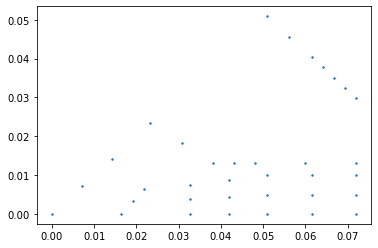

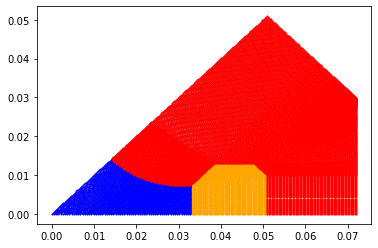

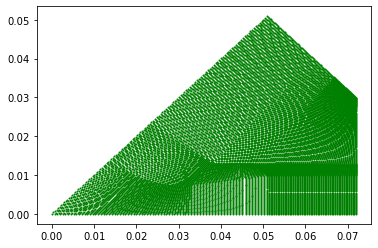

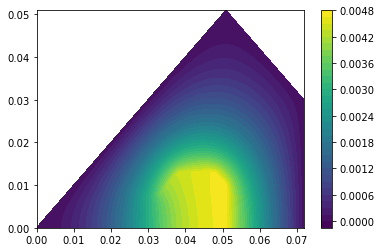

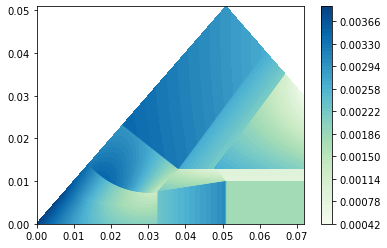

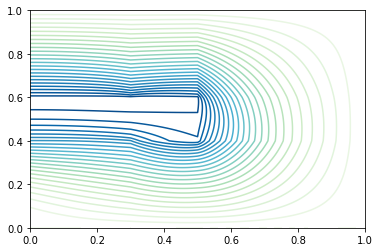

In [3]:

knots, weights, surface, O = create_geometry()
print(surface)

plt.figure()
plt.scatter(knots[:,:,0],knots[:,:,1],s=2)

basis1 = tt_iga.bspline.BSplineBasis(np.array([0,0.4,0.4,0.6,0.6,1]),2)
basis2 = tt_iga.bspline.BSplineBasis(np.array([0,0.15,0.3,0.5,1]),1)

geom = tt_iga.PatchNURBS([basis1, basis2],[], [tntt.TT(knots[:,:,0]), tntt.TT(knots[:,:,1])], tntt.TT(weights))

y1, y2 = np.linspace(0.4,0.6,64), np.linspace(0,0.5,64)
X1,X2 = geom([y1,y2])
plt.figure()
plt.scatter(X1.numpy().flatten(), X2.numpy().flatten(),s=1,c='orange')

y1, y2 = np.linspace(0,0.4,64), np.linspace(0,0.3,64)
X1,X2 = geom([y1,y2])
plt.scatter(X1.numpy().flatten(), X2.numpy().flatten(),s=1,c='blue')

y1, y2 = np.linspace(0.6,1,64), np.linspace(0,0.5,64)
X1,X2 = geom([y1,y2])
plt.scatter(X1.numpy().flatten(), X2.numpy().flatten(),s=1,c='red')

y1, y2 = np.linspace(0,1,128), np.linspace(0.5,1,128)
X1,X2 = geom([y1,y2])
plt.scatter(X1.numpy().flatten(), X2.numpy().flatten(),s=1,c='red')

y1, y2 = np.linspace(0,0.4,64), np.linspace(0.3,0.5,64)
X1,X2 = geom([y1,y2])
plt.scatter(X1.numpy().flatten(), X2.numpy().flatten(),s=1,c='red')

y1, y2 = np.linspace(0,1,128), np.linspace(0.,1,128)
X1,X2 = geom([y1,y2])
plt.figure()
plt.scatter(X1.numpy().flatten(), X2.numpy().flatten(),s=1,c='green')


mu0 = 4*np.pi*1e-7
mur = 1500
mu_ref = lambda y: 1/mu0*((y[...,1]<0.5)*(y[...,0]<0.6)*(y[...,0]>0.4)+(y[...,1]<0.3)*(y[...,0]<0.4))+1/(mu0*mur)*tn.logical_not((y[...,1]<0.5)*(y[...,0]<0.6)*(y[...,0]>0.4)+(y[...,1]<0.3)*(y[...,0]<0.4))

basis_solution = [tt_iga.bspline.BSplineBasis(np.concatenate((np.linspace(0,0.4,32), np.linspace(0.4,0.6,32),np.linspace(0.6,1,32))),2)]
basis_solution.append(tt_iga.bspline.BSplineBasis(np.concatenate((np.linspace(0,0.15,25),np.linspace(0.15,0.3,25), np.linspace(0.3,0.5,20),np.linspace(0.5,1,25))),2))
Mass_tt = geom.mass_interp(basis_solution)
Stiff_tt = geom.stiffness_interp(basis_solution, func_reference=mu_ref, eps = 1e-12)

J0 = 24*45/surface
Jref = lambda y: J0*(y[...,1]<0.5)*(y[...,0]<0.6)*(y[...,0]>0.4)+0.0

rhs_tt = geom.rhs_interp(basis_solution,Jref)

P1 = tn.eye(Mass_tt.N[0])
P2 = tn.eye(Mass_tt.N[1])
P2[-1,-1] = 0
P1[0,0] = 0
P1[-1,-1] = 0
Pin_tt = tntt.rank1TT([P1,P2])
Pbd_tt = tntt.eye(Mass_tt.N) - Pin_tt

M_tt = (Pin_tt@Stiff_tt+Pbd_tt).round(1e-12)
rhs_tt = (Pin_tt @ rhs_tt + 0).round(1e-12)

print('System matrix... ',flush=True)


print('Rank Mtt ',M_tt.R)
print('Rank rhstt ',rhs_tt.R)

tme = datetime.datetime.now() 
# dofs_tt = tntt.solvers.amen_solve(M_tt.cuda(), rhs_tt.cuda(), x0 = tntt.ones(rhs_tt.N).cuda(), eps = eps_solver, nswp = 50, kickrank = 4, preconditioner = 'c', verbose = False).cpu()
dofs_tt = tntt.solvers.amen_solve(M_tt, rhs_tt, x0 = tntt.ones(rhs_tt.N), eps = 1e-9, nswp = 60, kickrank = 4, preconditioner = 'c', verbose = True)
tme = datetime.datetime.now() - tme
print('Time system solve ',tme,flush=True)



plt.figure()
y1, y2 = np.linspace(0,1,201), np.linspace(0.,1,201)
X1,X2 = geom([y1,y2])
u = dofs_tt.mprod([tn.tensor(basis_solution[0](y1).T),tn.tensor(basis_solution[1](y2).T)],[0,1])
plt.contourf(X1.numpy(), X2.numpy(),u.numpy(),levels=32)
plt.colorbar()
omega = geom.eval_omega([tn.tensor(y1), tn.tensor(y2)])

plt.figure()
plt.contourf(X1.numpy(), X2.numpy(),omega.numpy(),levels=64, cmap = 'GnBu')
plt.colorbar()

plt.figure()
Y1, Y2 = np.meshgrid(y1,y2)
plt.contour(Y1,Y2,u.numpy(),levels=24,cmap='GnBu')




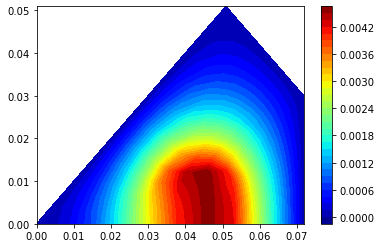

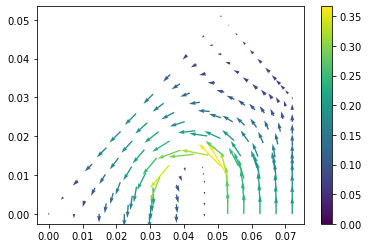

In [4]:
fspace = tt_iga.Function(basis_solution)
fspace.dofs = dofs_tt

plt.figure()
y1, y2 = np.linspace(0,1,12), np.linspace(0.,1,12)
x1,x2 = geom([y1,y2])
u = fspace([tn.tensor(y1),tn.tensor(y2)])
plt.contourf(x1.numpy(), x2.numpy(),u.numpy(),levels=32,cmap='jet')
plt.colorbar()

grad1, grad2 = geom.gradient_physical(basis_solution, fspace)
g2 = grad1([tn.tensor(y1),tn.tensor(y2)])
g1 = -grad2([tn.tensor(y1),tn.tensor(y2)])

plt.figure()
plt.quiver(x1.numpy().flatten(),x2.numpy().flatten(),-g1.numpy().flatten(),-g2.numpy().flatten(),np.sqrt(g1.numpy().flatten()**2+g2.numpy().flatten()**2))
plt.colorbar()

plt.savefig('B.jpeg')



Text(0, 0.5, '$x_2$ [mm]')

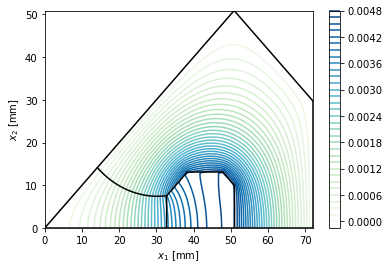

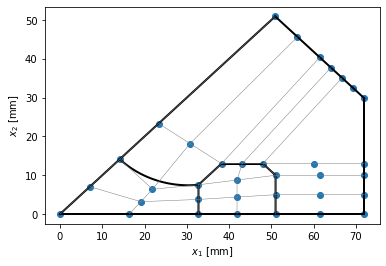

In [5]:


plt.figure()
y1, y2 = np.linspace(0,1,100), np.linspace(0.,1,100)
X1,X2 = geom([y1,y2])
u = dofs_tt.mprod([tn.tensor(basis_solution[0](y1).T),tn.tensor(basis_solution[1](y2).T)],[0,1])
plt.contour(X1.numpy()*1e3, X2.numpy()*1e3, u.numpy(),levels=32, cmap='GnBu')
line = geom([tn.linspace(0,0.4,32),tn.tensor([0.3])])
plt.plot(line[0].numpy().squeeze()*1e3, line[1].numpy().squeeze()*1e3, 'k')
line = geom([tn.linspace(0.4,0.6,32),tn.tensor([0.5])])
plt.plot(line[0].numpy().squeeze()*1e3, line[1].numpy().squeeze()*1e3, 'k')
line = geom([tn.linspace(0,1,32),tn.tensor([1])])
plt.plot(line[0].numpy().squeeze()*1e3, line[1].numpy().squeeze()*1e3, 'k')
line = geom([tn.linspace(0,1,32),tn.tensor([0.0])])
plt.plot(line[0].numpy().squeeze()*1e3, line[1].numpy().squeeze()*1e3, 'k')

line = geom([tn.tensor([0.0]),tn.linspace(0,1,32)])
plt.plot(line[0].numpy().squeeze()*1e3, line[1].numpy().squeeze()*1e3, 'k')
line = geom([tn.tensor([1.0]),tn.linspace(0,1,32)])
plt.plot(line[0].numpy().squeeze()*1e3, line[1].numpy().squeeze()*1e3, 'k')
line = geom([tn.tensor([0.4]),tn.linspace(0,0.5,32)])
plt.plot(line[0].numpy().squeeze()*1e3, line[1].numpy().squeeze()*1e3, 'k')
line = geom([tn.tensor([0.6]),tn.linspace(0,0.5,32)])
plt.plot(line[0].numpy().squeeze()*1e3, line[1].numpy().squeeze()*1e3, 'k')
plt.xlabel(r'$x_1$ [mm]')
plt.ylabel(r'$x_2$ [mm]')
plt.colorbar()
import tikzplotlib
tikzplotlib.save('quad_solution.tex')
plt.savefig('quad_solution.eps')

plt.figure()
line = geom([tn.linspace(0,0.4,32),tn.tensor([0.3])])
plt.plot(line[0].numpy().squeeze()*1e3, line[1].numpy().squeeze()*1e3, 'k', linewidth = 2)
line = geom([tn.linspace(0.4,0.6,32),tn.tensor([0.5])])
plt.plot(line[0].numpy().squeeze()*1e3, line[1].numpy().squeeze()*1e3, 'k', linewidth = 2)
line = geom([tn.linspace(0,1,32),tn.tensor([1])])
plt.plot(line[0].numpy().squeeze()*1e3, line[1].numpy().squeeze()*1e3, 'k', linewidth = 2)
line = geom([tn.linspace(0,1,32),tn.tensor([0.0])])
plt.plot(line[0].numpy().squeeze()*1e3, line[1].numpy().squeeze()*1e3, 'k', linewidth = 2)

line = geom([tn.tensor([0.0]),tn.linspace(0,1,32)])
plt.plot(line[0].numpy().squeeze()*1e3, line[1].numpy().squeeze()*1e3, 'k', linewidth = 2)
line = geom([tn.tensor([1.0]),tn.linspace(0,1,32)])
plt.plot(line[0].numpy().squeeze()*1e3, line[1].numpy().squeeze()*1e3, 'k', linewidth = 2)
line = geom([tn.tensor([0.4]),tn.linspace(0,0.5,32)])
plt.plot(line[0].numpy().squeeze()*1e3, line[1].numpy().squeeze()*1e3, 'k', linewidth = 2)
line = geom([tn.tensor([0.6]),tn.linspace(0,0.5,32)])
plt.plot(line[0].numpy().squeeze()*1e3, line[1].numpy().squeeze()*1e3, 'k', linewidth = 2)
plt.scatter(knots[...,0]*1e3, knots[...,1]*1e3)

plt.plot(knots[:,1,0]*1e3, knots[:,1,1]*1e3,'gray',linewidth=0.5)
plt.plot(knots[:,2,0]*1e3, knots[:,2,1]*1e3,'gray',linewidth=0.5)
plt.plot(knots[:,3,0]*1e3, knots[:,3,1]*1e3,'gray',linewidth=0.5)
plt.plot(knots[0,:,0]*1e3, knots[0,:,1]*1e3,'gray',linewidth=0.5)
plt.plot(knots[1,:,0]*1e3, knots[1,:,1]*1e3,'gray',linewidth=0.5)
plt.plot(knots[2,:,0]*1e3, knots[2,:,1]*1e3,'gray',linewidth=0.5)
plt.plot(knots[3,:,0]*1e3, knots[3,:,1]*1e3,'gray',linewidth=0.5)
plt.plot(knots[4,:,0]*1e3, knots[4,:,1]*1e3,'gray',linewidth=0.5)

plt.xlabel(r'$x_1$ [mm]')
plt.ylabel(r'$x_2$ [mm]')


In [6]:
def get_in_reference(x, param1):
    return 0.4*x/(3.27640e-2+param1)

xs = tn.linspace(0,0.015,11)
A = fspace([get_in_reference(xs,0),tn.tensor([0])]).numpy().flatten()


data = {'x_positions': xs.numpy() ,'A':A}

xf = tn.linspace(0,0.015,128)
Af = fspace([get_in_reference(xf,0),tn.tensor([0])]).numpy().flatten()

data['xf'] = xf
data['Af'] = Af

import pickle
with open('measurements2.pkl','wb') as f:
    pickle.dump(data, f)




In [7]:
print(geom([tn.tensor([0.2]),tn.tensor([0.3])])[0].numpy().squeeze())
print(geom([tn.tensor([0.2]),tn.tensor([0.3])])[1].numpy().squeeze())

print(knots[:,:,1])
print(weights)

xc = geom([tn.linspace(0,0.4,10000),tn.tensor([0.3])])[0].numpy().squeeze()
yc = geom([tn.linspace(0,0.4,10000),tn.tensor([0.3])])[1].numpy().squeeze()
print(np.std(np.sqrt((xc-O[0])**2+(yc-O[1])**2)))

v = np.array([xc[1]-xc[0],yc[1]-yc[0]])
v = v / v[0]
print(v)


0.022707114613985436
0.008739171248728939
[[0.         0.00707107 0.01414214 0.02333452 0.05091169]
 [0.         0.00320185 0.00640369 0.01816726 0.04563961]
 [0.         0.00377588 0.00755176 0.013      0.04036753]
 [0.         0.00438794 0.00877588 0.013      0.03773149]
 [0.         0.005      0.01       0.013      0.03509545]
 [0.         0.005      0.01       0.013      0.03245942]
 [0.         0.005      0.01       0.013      0.02982338]]
[[1.         1.         1.         1.         1.        ]
 [1.         1.         0.90250366 1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]]
7.40789891621665e-18
[ 1.         -0.99991386]
